# Identifying Ames, Iowa Housing Prices - EDA and Modeling

## Contents:
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
    - [Dummies](#Dummies)
    - [Linear Models](#Linear-Models)
    - [Submission](#Submission)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Exploratory Data Analysis

In [668]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

In [631]:
# Import datasets
df = pd.read_csv('../datasets/clean_train.csv', index_col = 0)
test_df = pd.read_csv('../datasets/clean_test.csv', index_col = 0)

In [632]:
# Look at training dataset
df.head()

,id,saleprice,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,wood_deck_sf,open_porch_sf,lot_area,...,bsmtfin_type_1,ms_zoning,neighborhood,condition_1,foundation,year_remod/add,year_built,garage_yr_blt,sale_type,fireplaces
0,109,130500,533.0,192.0,725.0,725,754,0,44,13517,...,5,RL,Sawyer,RRAe,CBlock,2005,1976,1976.0,WD,0
1,544,220000,637.0,276.0,913.0,913,1209,0,74,11492,...,5,RL,SawyerW,Norm,PConc,1997,1996,1997.0,WD,1
2,153,109000,731.0,326.0,1057.0,1057,0,0,52,7922,...,5,RL,NAmes,Norm,CBlock,2007,1953,1953.0,WD,0
3,318,174000,0.0,384.0,384.0,744,700,100,0,9802,...,0,RL,Timber,Norm,PConc,2007,2006,2007.0,WD,0
4,255,138500,0.0,676.0,676.0,831,614,0,59,14235,...,0,RL,SawyerW,Norm,PConc,1993,1900,1957.0,WD,0


In [633]:
# Identifying dtypes - seeing what columns will become dummied for modeling
to_dum_cols = ['ms_zoning', 'neighborhood', 'condition_1', 'foundation', 'bsmt_exposure', 'bsmtfin_type_1', 'sale_type']
df.dtypes

id                  int64
saleprice           int64
bsmtfin_sf_1      float64
bsmt_unf_sf       float64
total_bsmt_sf     float64
1st_flr_sf          int64
2nd_flr_sf          int64
wood_deck_sf        int64
open_porch_sf       int64
lot_area            int64
mas_vnr_area      float64
gr_liv_area         int64
garage_area       float64
screen_porch        int64
full_bath           int64
totrms_abvgrd       int64
lot_frontage      float64
half_bath           int64
bedroom_abvgr       int64
overall_qual        int64
exter_qual          int64
bsmt_qual           int64
kitchen_qual        int64
bsmt_exposure       int64
bsmtfin_type_1      int64
ms_zoning          object
neighborhood       object
condition_1        object
foundation         object
year_remod/add      int64
year_built          int64
garage_yr_blt     float64
sale_type          object
fireplaces          int64
dtype: object

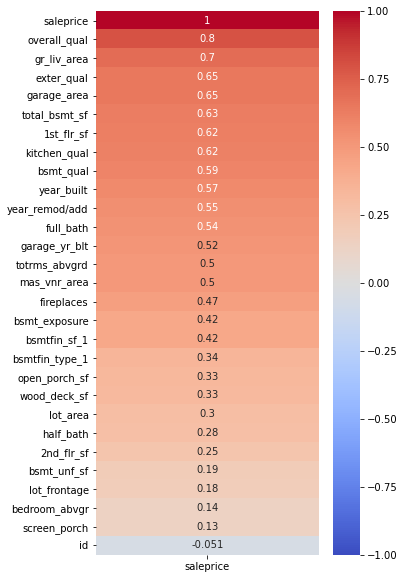

In [634]:
# Preliminary feature presentation
plt.figure(figsize = (5, 10))
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice', ascending = False),
            annot = True,
            cmap = 'coolwarm',
            vmin = -1, vmax = 1);

In [635]:
# Splitting features
corr_df = df.corr()[['saleprice']]
high_corr = corr_df[corr_df['saleprice'] > 0.5]
low_corr = corr_df[corr_df['saleprice'] <= 0.5]

all_ft = list(corr_df.index)

low_ft = list(low_corr.index)
low_ft.remove('id')

high_ft = list(high_corr.index)
high_ft.remove('saleprice')

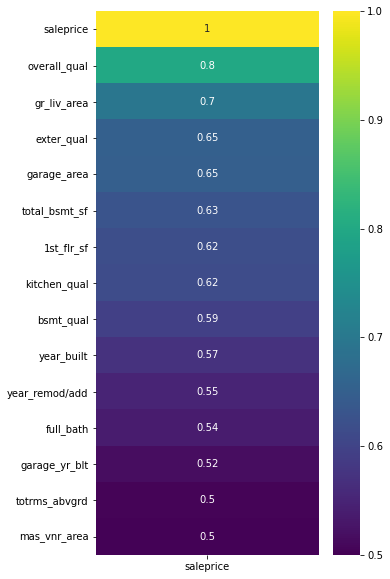

In [636]:
# High correlation features
plt.figure(figsize = (5, 10))
sns.heatmap(df[['saleprice']+high_ft].corr()[['saleprice']].sort_values('saleprice', ascending = False),
            annot = True,
            cmap = 'viridis',
            vmin = 0.5, vmax = 1);

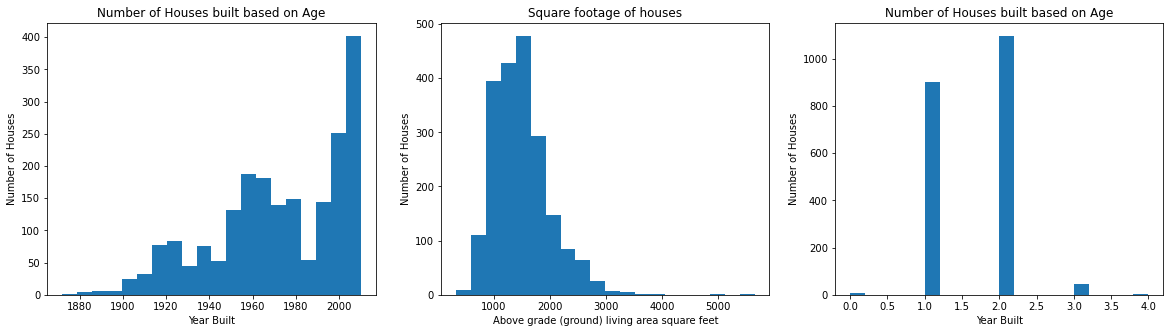

In [637]:
# Basic histogram subplots
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

# Detail example
ax[0].hist(df['year_built'], bins = 20)
ax[0].set_xlabel('Year Built')
ax[0].set_ylabel('Number of Houses')
ax[0].set_title('Number of Houses built based on Age')

# Area example
ax[1].hist(df['gr_liv_area'], bins = 20)
ax[1].set_xlabel('Above grade (ground) living area square feet')
ax[1].set_ylabel('Number of Houses')
ax[1].set_title('Square footage of houses')

# Detail example
ax[2].hist(df['full_bath'], bins = 20)
ax[2].set_xlabel('Year Built')
ax[2].set_ylabel('Number of Houses')
ax[2].set_title('Number of Houses built based on Age');

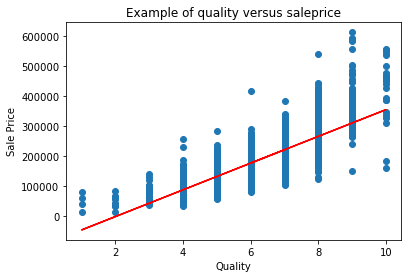

In [638]:
# Quality example
x_line, y_line = df['overall_qual'], df['saleprice']
m, b = np.polyfit(x_line, y_line, 1)

plt.scatter(x_line, y_line)
plt.plot(x_line, m*x_line + b, c ='r')
plt.xlabel('Quality')
plt.ylabel('Sale Price')
plt.title('Example of quality versus saleprice');

## Modeling

### Dummies

In [639]:
to_dum_cols

['ms_zoning',
 'neighborhood',
 'condition_1',
 'foundation',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'sale_type']

In [640]:
# Function to get tuple of dummy columns along with list of features for insertion
def cat_dum(dataframe, column):
    # Get dummies
    dums = pd.get_dummies(dataframe[column])
    dums = dums.iloc[:, 1:] # Drop one column due to redundancy
    
    # Get column names for feature insertion
    dum_columns = dums.columns.values
    dum_features = dum_columns.tolist()
    
    # Return tuple
    return (dums, dum_features)

In [641]:
# Function to get see if feature is useful for modeling
def test_relevance(dataframe, column):
    # Get new dataframe for testing
    to_merge, features = cat_dum(dataframe, column)
    test_df = df
    test_df = test_df.merge(to_merge, left_index = True, right_index = True)
    
    # Test features on linear regression model
    lr = LinearRegression()
    X = test_df[features]
    y = test_df['saleprice']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    lr.fit(X_train, y_train)

    # Cross_val_score not used due to overfitting
    print('{}: Training score is {}., Test score is {}.'\
          .format(column, \
                  round(lr.score(X_train, y_train), 3), \
                  round(lr.score(X_test, y_test), 3)));

In [642]:
# Function to merge dummies and return dummy features
def merge_dfs(dataframe, column):
    to_merge, features = cat_dum(dataframe, column)
    test_df = dataframe
    test_df = test_df.merge(to_merge, left_index = True, right_index = True)
    # Return merged dataframe and feature names
    return (test_df, features)

In [643]:
# Identifying relevant columns to use for modeling
for col in to_dum_cols:
    test_relevance(df, col)

ms_zoning: Training score is 0.101., Test score is 0.138.
neighborhood: Training score is 0.589., Test score is 0.54.
condition_1: Training score is 0.048., Test score is 0.053.
foundation: Training score is 0.282., Test score is 0.307.
bsmt_exposure: Training score is 0.177., Test score is 0.245.
bsmtfin_type_1: Training score is 0.219., Test score is 0.224.
sale_type: Training score is 0.148., Test score is 0.124.


Relevant categorical columns to be used are ms_zoning, neighborhood, foundation, bsmtfin_type_1, sale_type.

Others are disqualified due to not having a high enough score or large disparity between the scores.

In [644]:
# Create full dataframe
cat_features = ['neighborhood', 'foundation', 'bsmtfin_type_1', 'sale_type']

full_df = df
dum_features = []
for col in cat_features:
    full_df = merge_dfs(full_df, col)[0]
    dum_features = dum_features + merge_dfs(full_df,col)[1]
    
# Copy for test set
dum_test_df = test_df
test_features = []
for col in cat_features:
    dum_test_df = merge_dfs(dum_test_df, col)[0]
    test_features = test_features + merge_dfs(dum_test_df, col)[1]
    
print(dum_features)
full_df.head()

['Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood', 1, 2, 3, 4, 5, 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth', 'WD ']


,id,saleprice,bsmtfin_sf_1,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,wood_deck_sf,open_porch_sf,lot_area,...,4,5,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
0,109,130500,533.0,192.0,725.0,725,754,0,44,13517,...,0,1,0,0,0,0,0,0,0,1
1,544,220000,637.0,276.0,913.0,913,1209,0,74,11492,...,0,1,0,0,0,0,0,0,0,1
2,153,109000,731.0,326.0,1057.0,1057,0,0,52,7922,...,0,1,0,0,0,0,0,0,0,1
3,318,174000,0.0,384.0,384.0,744,700,100,0,9802,...,0,0,0,0,0,0,0,0,0,1
4,255,138500,0.0,676.0,676.0,831,614,0,59,14235,...,0,0,0,0,0,0,0,0,0,1


### Linear Models

In [645]:
# Baseline model - Kaggle base contains 181479.1217 as baseline
dum = DummyRegressor()
X = df[all_ft[2:]]
y = df['saleprice']
dum.fit(X, y)
dum.predict(X)

array([181469.70160897, 181469.70160897, 181469.70160897, ...,
       181469.70160897, 181469.70160897, 181469.70160897])

In [646]:
# Testing out model on highly correlating features
lr = LinearRegression()
features = high_ft
X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test), cross_val_score(lr, X_train, y_train).mean()

(0.7883117153071548, 0.8481389303595086, 0.7676747087089899)

In [647]:
# Testing out model on lower correlating features
lr = LinearRegression()
features = low_ft
X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test), cross_val_score(lr, X_train, y_train).mean()

(0.6227419853069022, 0.6659676865007871, 0.5729081908394268)

In [648]:
# Model using both sets of features
lr = LinearRegression()
features = high_ft + low_ft
X = df[features]
y = df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test), cross_val_score(lr, X_train, y_train).mean()

(0.8146090740254249, 0.8632023615149061, 0.7749123170840546)

In [649]:
# Model using both sets of features + dummy categories
lr = LinearRegression()
features = high_ft + low_ft + dum_features
X = full_df[features]
y = full_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test), cross_val_score(lr, X_train, y_train).mean()

(0.8549819769419146, 0.8707076119866488, 0.8099230229174449)

In [661]:
# Model using only dummy categories
lr = LinearRegression()
features = dum_features
X = full_df[features]
y = full_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test), cross_val_score(lr, X_train, y_train).mean()

(0.6408226760499245, 0.5967385003548031, 0.6131959590459367)

In [654]:
def rounded(list):
    return [round(num, 3) for num in list]

In [656]:
rounded([0.7883117153071548, 0.8481389303595086, 0.7676747087089899])

[0.788, 0.848, 0.768]

In [663]:
pd.DataFrame({
     'score': ['train', 'test', 'cross_val'],
     'high_corr': rounded([0.7883117153071548, 0.8481389303595086, 0.7676747087089899]),
     'low_corr': rounded([0.6227419853069022, 0.6659676865007871, 0.5729081908394268]),
     'full_corr': rounded([0.8146090740254249, 0.8632023615149061, 0.7749123170840546]),
     'cat': rounded([0.6408226760499245, 0.5967385003548031, 0.6131959590459367]),
     'with_cat': rounded([0.8549819769419146, 0.8707076119866488, 0.8099230229174449])})

,score,high_corr,low_corr,full_corr,cat,with_cat
0,train,0.788,0.623,0.815,0.641,0.855
1,test,0.848,0.666,0.863,0.597,0.871
2,cross_val,0.768,0.573,0.775,0.613,0.810


### Submission

In [650]:
# # First try at combining test and train csvs
# lr = LinearRegression()
# features = high_ft + low_ft
# X_train = df[features]
# y_train = df['saleprice']

# X_find = test_df[features]

# lr.fit(X_train, y_train)

# submit_id = test_df['id']
# submit_saleprice = lr.predict(X_find)

# submit_df = pd.DataFrame({'Id': submit_id, 'SalePrice': submit_saleprice})

# submit_df = submit_df.sort_values('Id')
# # submit_df = submit_df.reset_index(drop = True)
# submit_df = submit_df.set_index('Id')
# submit_df.to_csv('../datasets/submission1.csv')

In [667]:
# Submission with all features
lr = LinearRegression()
features = dum_features

# Bug fix bandaid
for i in ['GrnHill', 'Landmrk']:
    features.remove(i)

X = full_df[features]
y = full_df['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Copy model, features, X, y above and change submission# for new submission
X_find = dum_test_df[features]

lr.fit(X_train, y_train)

submit_id = dum_test_df['id']
submit_saleprice = lr.predict(X_find)

submit_df = pd.DataFrame({'Id': submit_id, 'SalePrice': submit_saleprice})

submit_df = submit_df.sort_values('Id')
# submit_df = submit_df.reset_index(drop = True)
submit_df = submit_df.set_index('Id')
submit_df.to_csv('../datasets/submission5.csv')

## Conclusions and Recommendations

This project was able to identify key factors in sale pricing. Overfitting was prominent along all numerical features. Location features predicted sale price surprisingly well. With the categorical features, the train and test scores were closer. Final predictive score was +80% and a RMSE score of ~31.5k was shown.

Based on the numerical data, the two main factors were house quality and house space. This is to be expected as the quantity and quality of a good is usually the most important in a sale. However, it is shown that the space outside of the house, such as lot area, were significantly less of a factor in determining the price. Another factor that was important were house factors such as the number of bathrooms, bedrooms, and fireplaces. 

In order to get the highest sale price in a house, quality should be highly focused on. Visuals highlighting the relationship between quality and sale price has shown that price can vary hundreds of thousands of dollars based on the quality of the house. For anyone looking to improve the value of their house, I would highly recommend raising the quality and condition of the house.